In [6]:
# imports
import string
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['seaborn-poster', 'science', 'no-latex'])
from scipy.linalg import eigh
import matplotlib.cm as cm
from scipy.spatial import cKDTree
import pandas as pd

import sys
sys.path.append("..")
import common
import importlib
importlib.reload(common)

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

In [7]:
# stolen from notebook9
filename = "glove.6B.50d.txt"

embeddings = {}
with open(filename,'r', encoding='utf-8') as file:
    for line in file:
        elements = line.split();
        word = elements[0];
        vector = np.asarray(elements[1:],"float32")
        embeddings[word] = vector

In [8]:
# functions
def mean_emb(text):
    pre = text.split()
    sum_emb = np.zeros(50,)
    for word in pre:
        if word in embeddings:
            sum_emb += embeddings[word]
    mean_emb = sum_emb/50
    
    return mean_emb

def glove_accuracy(X_train, X_test, y_train, y_test):
    train_embeddings = np.array([mean_emb(text) for text in X_train])
    test_embeddings = np.array([mean_emb(text) for text in X_test])

    clf = GaussianNB().fit(train_embeddings, y_train)

    predictions = clf.predict(test_embeddings)
    accuracy = accuracy_score(y_test, predictions)

    return round(accuracy,ndigits=3)

In [4]:
## Spam data

In [5]:
spam_train, spam_test = common.load_data('spam')
glove_accuracy(spam_train['texts'], spam_test['texts'], spam_train['labels'], spam_test['labels'])

0.934

In [6]:
news_train, news_test = common.load_data('news')
glove_accuracy(news_train['texts'], news_test['texts'], news_train['labels'], news_test['labels'])

0.84

## PCA

## sms

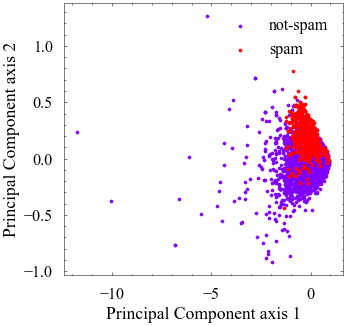

In [17]:
spam_train_emb =common.get_train_emb(spam_train['texts'], mean_emb)
spam_pca = common.pca(spam_train_emb)

common.plot_pca(spam_pca, spam_train['labels'], [0,2], None)

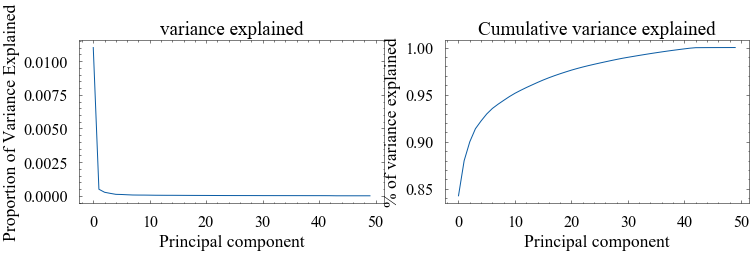

In [18]:
common.pca_variance_plots(eigenValues=spam_pca[0])

This shows around 88% variance at 2 components

Maybe add a vertical line at x=2

### News

Currently it just shows the first 5000 articles, we could maybe change it to be 5000 random. np.random.choice()

Or we could just say that the first 5k are representative of the population

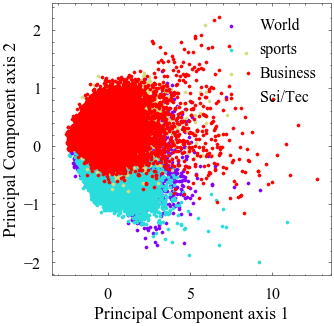

In [19]:
news_train_emb =common.get_train_emb(news_train['texts'], mean_emb)
news_pca = common.pca(news_train_emb)
common.plot_pca(news_pca, news_train['labels'], [0,2], 5000)

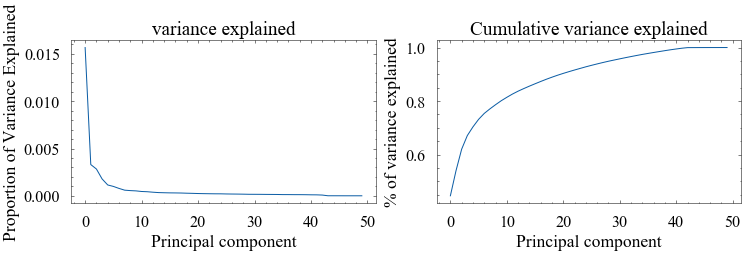

In [20]:
common.pca_variance_plots(eigenValues=news_pca[0])

ideally we would need 10 components to explain 80% variance

## Similar news

In [9]:
new_news = common.load_similar_news("../similar_news.txt")

In [10]:
all_news = {'texts': np.append(news_train['texts'],new_news['texts']),
            'labels': np.append(news_train['labels'],new_news['labels'])}
all_news['texts'][-14:]

array(['The rise of self-driving taxis in China comes at a time when people are nervous about taking public transport.',
       'A woman who accuses Democratic White House candidate Joe Biden of sexually assaulting her 27 years ago has called on him to quit the presidential race.',
       'Germany\'s parliament has passed a law banning so-called "gay conversion therapy" for young people nationwide.',
       "The UK's most modern nuclear power station could be partially powered down as the National Grid looks to manage lower energy demands.",
       "World Athletics says Nike's controversial Vaporfly range will not be banned but there will be tighter regulations around high-tech running shoes.",
       'Formula 1 chairman Chase Carey has admitted that the sport\'s owners are preparing for "the remote possibility of no racing in 2020".',
       "Anthony Joshua's next bout could take place in a Roman amphitheatre in Croatia, says the manager of mandatory challenger Kubrat Pulev.",
       

In [11]:
X_train_emb = common.get_train_emb(all_news['texts'], mean_emb)
eigenValues, eigenVectors, data = common.pca(X_train_emb)

In [29]:
def plot_pca(X_train, y_train, PC_range, num_texts, examples):
    global eigenValues, eigenVectors, data
    #plot for the selected two principal components
    X_proj = eigenVectors[:,PC_range[0]:PC_range[1]].T@data    
    n_label = len(np.unique(y_train))
 
    if n_label == 2:
        considered_classes = ['Not-spam','Spam']
    else:
        considered_classes = ['World','Sports', 'Business', 'Sci/Tec']
        
    colors = cm.rainbow(np.linspace(0, 1, n_label))
    cdict = {i: colors[i] for i in range(n_label)}
    label_dict = {i: considered_classes[i] for i in range(n_label)}
    
    f = plt.figure(figsize=(10,7))
    class_idx = y_train[:num_texts]
    for i in range(n_label):
        indices = np.where(class_idx == i)
        plt.scatter(X_proj[0,indices], X_proj[1,indices],
                 color=cdict[i], label=label_dict[i],s=5)
    if examples:
        class_idx = y_train[-14:]
        for i in range(n_label):
            indices = np.where(class_idx == i)
            if i == 0:
                marker = 'v'
            elif i == 1:
                marker = '^'
            elif i == 2:
                marker = '.'
            elif i == 3:
                marker = 'o'
            plt.scatter(X_proj[0,indices], X_proj[1,indices],
                        label=label_dict[i],s=60, color='black', marker=marker)
    plt.legend(loc='best')
    plt.xlabel('Principal Component axis 1');
    plt.ylabel('Principal Component axis 2');
    plt.show()

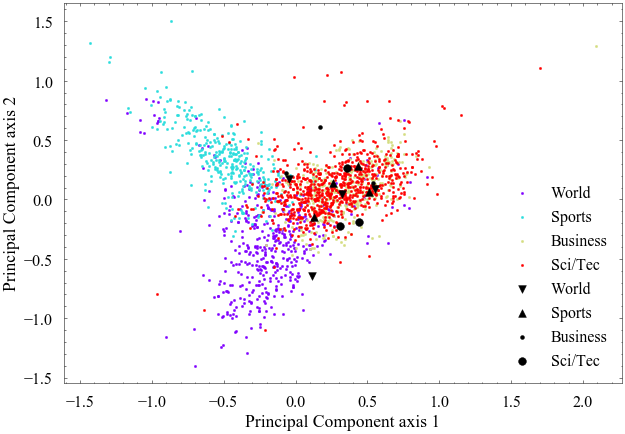

In [30]:
#notice that the difference from the previous plot,
#when we changed the principal components to be 1 to 3 instead of 0 to 2
plot_pca(all_news['texts'], all_news['labels'], [1,3], 2000, True)

### Getting coordinates from PCA plot

In [47]:
def get_coords(X_train, y_train, PC_range, queries):
    global eigenValues, eigenVectors, data
    X_proj = eigenVectors[:,PC_range[0]:PC_range[1]].T@data  
    
    x_new = X_proj[0,:]
    y_new = X_proj[1,:]
       
    if queries < 0:
        coordmat = np.zeros((abs(queries),2))
        coordmat[:abs(queries),0] = x_new[queries:]
        coordmat[:abs(queries),1] = y_new[queries:]
    else:
        coordmat = np.zeros((queries,2))
        coordmat[:queries,0] = x_new[:queries]
        coordmat[:queries,1] = y_new[:queries]  
           
    return coordmat

In [48]:
coordmat = get_coords(all_news['texts'], all_news['labels'], [1,3], 120_000)
queries = get_coords(all_news['texts'], all_news['labels'], [1,3], -14)

print(queries.shape)
print(coordmat.shape)

(14, 2)
(120000, 2)


In [32]:
def nearest_neighbor(coordmat, queries, k):
    Tree = cKDTree(coordmat, leafsize=100)
    
    dist, idx = Tree.query(queries,k=k)
    originalid = idx
    # note when we are doing this, we are assuming that the order is preserved
    nearest_neighbor = all_news['texts'][idx]
    
    return nearest_neighbor, originalid

nearest_neighbors, originalid = nearest_neighbor(coordmat, queries,3)

In [33]:
#sanity check that the returned article is indeed close
print(originalid)
print(queries[0,:])
print(coordmat[originalid[0,0],:])

[[ 73843  96799  87308]
 [ 32159  87956 111943]
 [ 54241  36632 100324]
 [ 59763  34938  27908]
 [104166  49958  88910]
 [ 21179  89524 111886]
 [ 33569   4482 101214]
 [ 97707  39539  34265]
 [ 22550 102279  51746]
 [ 68933 116263  48946]
 [116991  54447  79256]
 [ 61303  96535  45103]
 [ 44960 110172  10859]
 [ 33937  32802  33582]]
[ 0.035727   -0.07267638]
[ 0.03769976 -0.07264488]


## Comparing articles

In [34]:
#labels are ['World','Sports', 'Business', 'Sci/Tec']
for i in range(14):
    print("Article(s) in corpus","\n")
    print("label:", all_news['labels'][originalid[i]],",","text:", nearest_neighbors[i],"\n")
    print("Compared article","\n")
    print("label:", all_news['labels'][-14+i],",","text:", all_news['texts'][-14+i],"\n","\n")

Article(s) in corpus 

label: [2 2 3] , text: ['murdoch gets emotional as he moves out rupert murdoch is normally courteous to his shareholders , but they were reminded of their irrelevance at yesterday #39 s news corp annual meeting proxy votes had ensured 92 support for the move to the us state of delaware .'
 'boston #39 s big dig awash in troubles twenty years and \\$14 . 6 billion after its conception , the most ambitious public works project in the nation -- an unprecedented effort to route an unsightly highway deep beneath the central'
 'wanted by the police a good interface how the flawed interface design of a police dispatch system became a municipal issue in san jose .'] 

Compared article 

label: 0 , text: The rise of self-driving taxis in China comes at a time when people are nervous about taking public transport. 
 

Article(s) in corpus 

label: [0 0 0] , text: ['ivan , remnants blamed for 45 u . s . deaths wheeling , w . va . - remnants of hurricane ivan made a violent 

This should be compared to this list

- 0,3/2 https://www.bbc.com/news/business-52392366
- 0 https://www.bbc.com/news/world-us-canada-52584774 
- 0 https://www.bbc.com/news/world-europe-52585162
- 0, 3 https://www.bbc.com/news/uk-england-suffolk-52566082
- 1, 3 https://www.bbc.com/sport/av/athletics/51332721 
- 1 https://www.bbc.com/sport/formula1/52568642
- 1 https://www.bbc.com/sport/boxing/52573766
- 2 https://www.bbc.com/news/business-52570600
- 2 https://www.bbc.com/news/business-52580950 
- 2, 3 https://www.bbc.com/news/business-52570714 
- 3 https://www.bbc.com/news/science-environment-52550973 
- 3 https://www.bbc.com/news/technology-52572381
- 3 https://www.bbc.com/news/science-environment-52560812 

In some cases it is actually pretty accurate. Like this article

"Facebook and Google have said they will let employees continue working from home for the rest of the year. The tech giants have announced plans to reopen their offices soon but are allowing more home working flexibility."

We originally labeled it as 2, but it could quite easily be a 3, since Facebook and google are tech companies. Although the articles in the corpus are not similiar category they often have really similar content. In some cases only the class is the same though.

### Softmax scores from fastText

In [35]:
import text_classifier as text_clf

clf = text_clf.TextClassifier(all_news['texts'][:120_000], all_news['labels'][:120_000],embed_dim=23, ngrams=1, num_epochs=5)

0lines [00:00, ?lines/s]

Constructing vocabulary...


120000lines [00:12, 9310.75lines/s] 
  0%|▎                                                                          | 560/120000 [00:00<00:22, 5227.66it/s]

Preparing dataset...


100%|████████████████████████████████████████████████████████████████████████| 120000/120000 [00:22<00:00, 5255.30it/s]


Training model...
Epoch: 1  | time in 0 minutes, 38 seconds
	Loss: 0.0254(train)	|	Acc: 85.6%(train)
Epoch: 2  | time in 0 minutes, 24 seconds
	Loss: 0.0165(train)	|	Acc: 91.1%(train)
Epoch: 3  | time in 0 minutes, 23 seconds
	Loss: 0.0141(train)	|	Acc: 92.4%(train)
Epoch: 4  | time in 0 minutes, 22 seconds
	Loss: 0.0124(train)	|	Acc: 93.2%(train)
Epoch: 5  | time in 0 minutes, 24 seconds
	Loss: 0.0112(train)	|	Acc: 93.8%(train)



In [36]:
predicted_labels = [clf.predict(text) for text in all_news['texts'][-14:]]
predicted_prob = [clf.predict(text, return_prob=True).flatten() for text in all_news['texts'][-14:]]

In [37]:
# true labels 0;3/2 ,0, 0, 0;3, 1;3, 1, 1, 2, 2, 2;3, 3, 3, 3
true_labels = [0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3]
print("True label", true_labels)
print("Predicted label", predicted_labels)
print("Softmax scores")
predicted_prob

True label [0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3]
Predicted label [3, 0, 0, 3, 1, 1, 3, 1, 2, 0, 3, 3, 3, 0]
Softmax scores


[array([0.3232324 , 0.00479453, 0.11750805, 0.55446494], dtype=float32),
 array([9.8928457e-01, 5.4760494e-05, 8.7471809e-03, 1.9135843e-03],
       dtype=float32),
 array([9.9998546e-01, 2.9555997e-10, 5.0604031e-06, 9.5481300e-06],
       dtype=float32),
 array([1.42204845e-02, 6.12548101e-09, 7.57598085e-03, 9.78203535e-01],
       dtype=float32),
 array([0.1760329 , 0.36202526, 0.16002661, 0.30191523], dtype=float32),
 array([1.2533704e-04, 9.9970788e-01, 1.4141607e-04, 2.5255464e-05],
       dtype=float32),
 array([0.08822904, 0.05942238, 0.29093623, 0.5614123 ], dtype=float32),
 array([0.06280275, 0.84820396, 0.00971635, 0.07927697], dtype=float32),
 array([1.1221893e-01, 7.4890477e-06, 7.7869666e-01, 1.0907692e-01],
       dtype=float32),
 array([0.44411314, 0.1449616 , 0.2209979 , 0.18992727], dtype=float32),
 array([0.17566979, 0.02007974, 0.23649609, 0.5677543 ], dtype=float32),
 array([4.1861907e-03, 8.0520549e-04, 7.9679547e-04, 9.9421173e-01],
       dtype=float32),
 array

The softmax scores actually reflect the category of the article quite nicely. With the articles where we would have classified them among multiple categories, the softmax scores reflect this potential ambiguity in the sense that for the two classes we classified it as, it also shows high scores.

See for example the 4'th last articles. The model gave these scores [0.17566979, 0.02007974, 0.23649609, 0.5677543 ], this corresponds to our labeling which was 3/2 (0 indexed). It is about 0.3 higher for 3 than 2 which is a much smaller difference than for some of the categories where we only gave it one label. 

## PCA on fastText embeddings

In [38]:
def pca(X_train):
    vectors = np.zeros((23, len(X_train)))
    for i in range(len(X_train)):
        doc = X_train[i]
        vectors[:,i] = clf.get_text_embedding(X_train[i]).flatten()
    
    #pca on feature vectors for selected words
    mean_vector = np.mean(vectors,axis=1)
    data = vectors - mean_vector[:,None]
    #compute the covariance matrix
    S = np.cov(data)
    #obtain eigenvectors and eigenvalues
    eigenValues, eigenVectors = eigh(S)
    #sort according to size of eigenvalues
    sort_idx = np.argsort(eigenValues)[::-1]
    eigenValues = eigenValues[sort_idx]
    eigenVectors = eigenVectors[:, sort_idx]
    return eigenValues, eigenVectors, data
eigenValues, eigenVectors, data = pca(all_news['texts'])

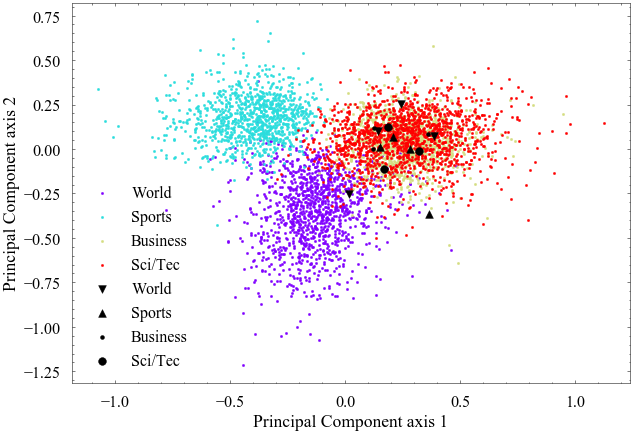

In [39]:
# The categories are separated better with fastText embeddings (probably related to the fact that it goes from 23 to 2
# dimension rather than from 50 to 2.)
plot_pca(all_news['texts'], all_news['labels'], [0,2], 5000, True)

In [40]:
coordmat = get_coords(all_news['texts'], all_news['labels'], [0,2], 120_000)
queries = get_coords(all_news['texts'], all_news['labels'], [0,2], -14)
nearest_neighbors, originalid = nearest_neighbor(coordmat, queries,3)
for i in range(14):
    print("Article(s) in corpus","\n")
    print("label:", all_news['labels'][originalid[i]],",","text:", nearest_neighbors[i],"\n")
    print("Compared article","\n")
    print("label:", all_news['labels'][-14+i],",","text:", all_news['texts'][-14+i],"\n","\n")

Article(s) in corpus 

label: [2 3 3] , text: ['nobody is neutral about the great google gamble the initial public offering of google brings to mind one of the great one-liners offered by clint eastwood in one of his dirty harry films quot opinions are like a**holes , quot harry says .'
 "relief in chicago no more ' frankenfish ' ( ap ) ap - an anxious search tuesday of a chicago harbor turned up no more northern snakeheads , a voracious alien fish that can devastate freshwater ecosystems by gobbling up food and native fish ."
 'genesis returns to earth iit will be 9 54 in the morning , mountain daylight time , on wednesday , september 8 , when the genesis sample return capsule , weighing 190 kilograms ( 420 pounds ) , will enter the earths atmosphere'] 

Compared article 

label: 0 , text: The rise of self-driving taxis in China comes at a time when people are nervous about taking public transport. 
 

Article(s) in corpus 

label: [0 0 2] , text: ['iran insists n-deal still on iran s

Output from above cell tends to change when training. Explanaition below might now fit. from a previous run with same parameters it had the following output

Article(s) in corpus 

label: [3 3 3]

'voq pro smart phone &lt strong&gt &lt cite&gt reg&lt /cite&gt review&lt /strong&gt a great idea - just a year too late ?'

"on the beastie boys ' virus ' cd &lt strong&gt review&lt /strong&gt does not attempt world domination ,
 
 but" 'locusts ravage northern nigeria the locusts swarming across west africa reach northern nigeria , devastating fields of crops .'

Compared article 

label: 3 , text: Astronomers have a new candidate in their search for the nearest black hole to Earth. 

It seems to be better at classifying Tech articles.

### Softmax scores for similar articles

In [75]:
#labels are ['World','Sports', 'Business', 'Sci/Tec']
predicted_prob = []
for i in range(np.size(originalid,axis=0)):
    for j in range(np.size(originalid,axis=1)):
        predicted_prob.append(clf.predict(all_news['texts'][originalid[i,j]], return_prob=True).flatten())
predicted_prob

[array([0.39465922, 0.00659692, 0.35732204, 0.24142182], dtype=float32),
 array([4.9390737e-02, 7.8773143e-04, 4.1754688e-03, 9.4564611e-01],
       dtype=float32),
 array([0.26599643, 0.00416852, 0.073549  , 0.65628606], dtype=float32),
 array([9.8927897e-01, 6.0411552e-05, 7.3284879e-03, 3.3322000e-03],
       dtype=float32),
 array([9.9054027e-01, 4.8011392e-05, 3.7474134e-03, 5.6643048e-03],
       dtype=float32),
 array([9.5173526e-01, 4.7127516e-05, 4.8134916e-02, 8.2721621e-05],
       dtype=float32),
 array([9.9998343e-01, 3.3465400e-10, 1.0838471e-05, 5.6654153e-06],
       dtype=float32),
 array([9.9998379e-01, 3.3082093e-10, 1.3519466e-05, 2.7223803e-06],
       dtype=float32),
 array([9.9997556e-01, 3.5787240e-10, 2.3390136e-05, 1.0624551e-06],
       dtype=float32),
 array([1.3788795e-02, 5.1088307e-09, 9.8574346e-01, 4.6768002e-04],
       dtype=float32),
 array([8.1028193e-03, 3.1294638e-09, 9.9175721e-01, 1.3997011e-04],
       dtype=float32),
 array([3.6981183e-03, 1.2

The scores above should reflect the scores from previously. e.g. the first

our 4-th last article which is category 3 (sci-tec) but could have been category 2 got these scores

[0.17566979, 0.02007974, 0.23649609, 0.5677543 ] (3)

The 3 most similar got the scores

[0.20269746, 0.02228613, 0.505274  , 0.2697425 ] (2)

[0.10673138, 0.01070143, 0.07527727, 0.80728996] (3)

[0.19573103, 0.01856374, 0.6601382 , 0.12556699] (2)


The scores for the articles classes are very similiar and are not that far from each other. With other documents that are clearly classified, we see a much bigger gap in the scores from the model. Here we are in the same order of tens, for some of the other classifications we are seeing spread in the order of $1\cdot10^4$ 

## Testing on emails with glove embeddings

We are using the "enron" email corpus with ~5k emails 

In [31]:
emails = common.load_emails("../emails.csv")

In [32]:
glove_accuracy(spam_train['texts'], emails['texts'], spam_train['labels'], emails['labels'])

0.662